<a href="https://colab.research.google.com/github/Abdibaset/ML_CS74/blob/main/HW4_abdibaset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [306]:
## load data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


data = pd.read_csv('hw4_naive.csv')
target_label = data['Label']
data.drop('Label', axis=1, inplace=True)
data.head()

X_train, X_test, y_train, y_test = train_test_split(data, target_label, test_size=0.2, random_state=27)


# **Evaluation Metrics**

In [307]:
def evaluate(y_actual, y_pred):
    y_actual = np.array(y_actual)
    y_pred = np.array(y_pred)
    false_positive = np.sum((y_actual == 0) & (y_pred == 1))
    false_negative = np.sum((y_actual == 1) & (y_pred == 0))
    true_positive = np.sum((y_actual == 1) & (y_pred == 1))
    true_negative = np.sum((y_actual == 0) & (y_pred == 0))

    accuracy = (true_positive + true_negative) / (false_positive + false_negative + true_positive + true_negative)

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    confusion_matrix = np.array([[true_negative, false_positive], [false_negative, true_positive]])

    print('Confusion Matrix:', confusion_matrix)
    print('Accuracy:', accuracy)
    print('F1 Score:', f1_score)

# **Multinomial Naive Bayes Implementation**

In [308]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import f1_score

class MultinomialNaiveBayes:
    def __init__(self, smoothing_alpha):
        self.feature_counts = defaultdict(lambda: defaultdict(int)) ## create nested dict for feature count associate with class
        self.class_counts = defaultdict(int) ## create dict for class count
        self.prior_probabilities = defaultdict(int) ## create dict for prior probabilities
        self.feature_likelihoods = defaultdict(lambda: defaultdict(int)) ## create nested dict for feature likelihood associate with class
        self.num_classes = 0
        self.smoothing_alpha = smoothing_alpha


    def calculate_prior_probabilities(self, y_train):
      """
      Calculate the probability of each class in the data set
      prob = count(class) / count(all)
      """
      for label in np.unique(y_train):
          self.prior_probabilities[label] = self.class_counts[label] / len(y_train)

    def calculate_feature_likelihoods(self):
      """
      - Calculates the hypothesis/ likelihood of feature occuring
      - Populates the likelihood dict
      - likehoold = (number of times feature occures + 1 ) / ( total number of features + number of classes)
      """
      for label in self.feature_counts.keys():
          for feature, value_count in self.feature_counts[label].items():
              self.feature_likelihoods[label][feature] = (value_count + self.smoothing_alpha) / (self.class_counts[label] + self.num_classes)

    def fit(self, X_train, y_train):
      """
      Calculates the class and feature counts to be used for prior prob calculation
      """
      self.num_classes = len(np.unique(y_train)) # get the number of classes
      for i in range(len(y_train)):
          label = y_train[i]
          self.class_counts[label] += 1
          ## loop over the rows of the train data and update the feature counts
          for feature, value in X_train.iloc[i].items():
              self.feature_counts[label][feature, value] += 1 ## update this feature's count

      self.calculate_prior_probabilities(y_train) # calculate the prior
      self.calculate_feature_likelihoods()

    def predict(self, X_test):
        y_pred = []
        for ind, row in X_test.iterrows():
          pred_dict = dict(self.prior_probabilities) # make copy of the prior evidence
          for label in pred_dict.keys():
            ## loop over the items in the row
              for feature, value in row.items():
                #get the likelihood/evidence, and if not present assign one
                  likelihood = self.feature_likelihoods[label].get((feature, value), 1 / (self.class_counts[label] + self.num_classes))
                  pred_dict[label] += np.log(likelihood) # scaling the likelihood to prevent extremely large or small probs

          pred_class = max(pred_dict, key=pred_dict.get)
          y_pred.append(pred_class)

        return y_pred


In [309]:
## testing Multinaive bayes model
multi_nb = MultinomialNaiveBayes(smoothing_alpha=1.0)
multi_nb.fit(X_train, np.array(y_train))
y_pred = multi_nb.predict(X_test)
evaluate(y_test, y_pred) # print the evaluation metrics

Confusion Matrix: [[569  63]
 [ 86 402]]
Accuracy: 0.8669642857142857
F1 Score: 0.8436516264428122


# **Gaussian Naive Bayes**

In [310]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import f1_score

class GaussianNaiveBayes:
    def __init__(self):
        self.class_probs = defaultdict(int)
        self.class_dict =  defaultdict(dict)
        self.feature_counts = defaultdict(lambda: defaultdict(int)) ## create nested dict for feature count associate with class
        self.class_counts = defaultdict(int) ## create dict for class count
        self.prior_probabilities = defaultdict(int) ## create dict for prior probabilities

    def calculate_prior_probabilities(self, y_train):
      """
      Calculate the probability of each class in the data set
      prob = count(class) / count(all)
      """
      for label in np.unique(y_train):
          self.prior_probabilities[label] = self.class_counts[label] / len(y_train)

    def fit(self, X_train, y_train):
      for i in range(len(y_train)):
          label = y_train[i]
          self.class_counts[label] += 1

          for feature, value in X_train.iloc[i].items():
              self.feature_counts[label][feature, value] += 1

      self.calculate_prior_probabilities(y_train) # calculate prior probabilities
      self.class_dict
      for label in self.feature_counts.keys():
          feature_vals = {feature: [val for i, val in enumerate(X_train[feature]) if y_train[i] == label] for feature in X_train.columns}

          # Calculate mean and variance for each feature
          self.class_dict[label]['mean_dict'] = {feature: np.mean(vals) if vals else 0 for feature, vals in feature_vals.items()}
          self.class_dict[label]['std_dict'] = {feature: np.std(vals) for feature, vals in feature_vals.items()}

    def gussian_val_calculation(self, value, feature, label):
        f_std = self.class_dict[label]['std_dict'][feature] # get the evidence std value
        f_means = self.class_dict[label]['mean_dict'][feature] # get the evidence mean value

        # Calculate the gaussian probability
        gaussian_term_1 = 1 / (np.sqrt(2 * np.pi * (f_std**2)))
        gaussian_term_2 = np.exp(-((value - f_means)**2) / (2 * (f_std**2)))
        return gaussian_term_1 * gaussian_term_2

    def predict(self, X_test):
        y_pred = []

        for ind, row in X_test.iterrows():
            pred_dict = dict(self.prior_probabilities) # make copy for the initial prorioty dict
            for label in pred_dict.keys():
                for feature, value in row.items():
                    likelihood = self.gussian_val_calculation(value, feature, label) # calculate the gaussian probability
                    likelihood = max(likelihood, 1e-5) # prevent taking the log of zero
                    pred_dict[label] += np.log(likelihood) # get logs to balance large and small values

            pred_class = max(pred_dict, key=pred_dict.get)
            y_pred.append(pred_class)

        return y_pred


In [311]:
gaussian_nb = GaussianNaiveBayes()
gaussian_nb.fit(X_train, np.array(y_train))
y_pred = gaussian_nb.predict(X_test)
evaluate(y_test, y_pred)

Confusion Matrix: [[539  93]
 [373 115]]
Accuracy: 0.5839285714285715
F1 Score: 0.33045977011494254


# **Clustering**

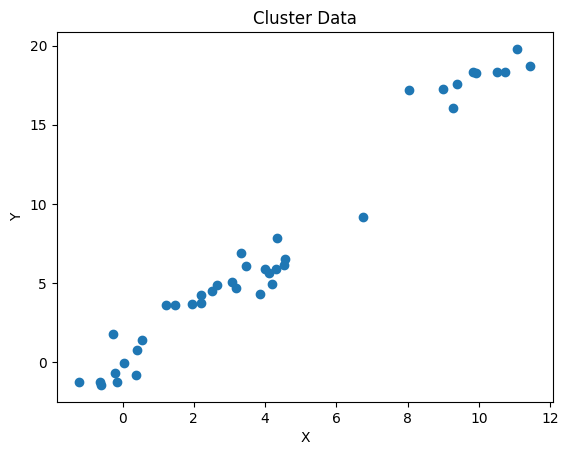

In [312]:
import matplotlib.pyplot as plt
%matplotlib inline
cluster_data = pd.read_csv("hw4_cluster.csv")
x = cluster_data.iloc[:, 0]
y = cluster_data.iloc[:, 1]
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Cluster Data')
plt.show()


In [313]:

import numpy as np
import random

# Util functions
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def centroid_mean(points):
    return np.mean(points, axis=0)

def random_seed_init(K, points):
    centroids = [[] for _ in range(K)]
    sorted_points = sorted(points, key=lambda x: x[1], reverse=True)
    points_split_by_x1 = np.array_split(sorted_points, K)
    for i in range(K):
        centroids[i] = points_split_by_x1[i][random.randint(0, len(points_split_by_x1[i]) - 1)]

    return centroids

# find closest bucket by centroid
def find_min_bucket(point, centroids):
    distances = [euclidean_distance(point[0], point[1], centroid[0], centroid[1]) for centroid in centroids]
    return np.argmin(distances)

def k_means(data, init_method, K=3, max_iters=50):
    buckets = np.array_split(data, K)

    if init_method == 'random_split' or init_method == None or init_method == '':
        centroids = [centroid_mean(bucket) for bucket in buckets]
    elif init_method == 'random_seed':
        centroids = random_seed_init(K, data)

    for _ in range(max_iters):
        change = False

        # update centroids and buckets in one pass
        new_centroids = [centroid_mean(bucket) for bucket in buckets]
        new_buckets = [[] for _ in range(K)]

        # iterate through each point in all buckets
        for point in data:
            closest = find_min_bucket(point, new_centroids) # find closest bucket
            new_buckets[closest].append(point)

            # check if the point's bucket has changed
            if closest != find_min_bucket(point, centroids): change = True

        # if no change, return buckets
        if not change:
          return np.array(new_buckets)

        # if change, update centroids and buckets
        centroids = new_centroids
        buckets = np.array(new_buckets)

    return np.array(new_buckets)



(40, 2)


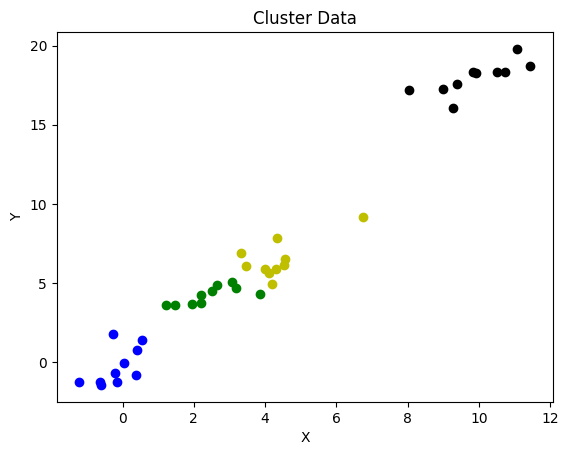

In [324]:
## test k-means
points = np.column_stack([x, y])
print(points.shape)
buckets = k_means(points, init_method='random_seed', K=5)

colors = ['b', 'g', 'y', 'black', 'r']
for i, bucket in enumerate(buckets):
    for point in bucket:
        plt.scatter(point[0], point[1], c=colors[i])

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Cluster Data')
plt.show()

# **Silhouette Score**

In [325]:

def silhouette_score(clusters):
    closest_cluster_dict = get_closest_clusters(clusters) # get closests in dict
    total_points = sum(len(cluster) for cluster in clusters)

    silhouette_scores = []
    for i in range(len(clusters)):
        cluster_i = clusters[i]
        for point in cluster_i:
          # get score for individual points
          silhouette_scores.append(get_point_score(point, cluster_i, clusters[closest_cluster_dict[i]]))

    # calculate total silhouette score
    return np.sum(silhouette_scores) / total_points

def get_closest_clusters(points):
    """
    - finds the closest clusters from the points given
    """
    closest_dict = defaultdict(int)

    for i, cluster_i in enumerate(points):
      if len(cluster_i) > 0:
          min_distance = float('inf')
          centroid_i = centroid_mean(cluster_i)  # centroid of the current out loop cluster

          # loop over all clusters
          for j, cluster_j in enumerate(points):
              if i != j:
                  # centroid of the inner loop cluster
                  centroid_j = centroid_mean(cluster_j)

                  # calculate euclidean distance between the outer loop and inner loop centroids
                  euclidean_dist = euclidean_distance(centroid_i[0], centroid_i[1], centroid_j[0], centroid_j[1])

                  # update the mean distance if current euclidean is less
                  if euclidean_dist < min_distance:
                      closest_dict[i] = j
                      min_distance = euclidean_dist  # Fix: Use euclidean_dist instead of euclidean_distance
    return closest_dict

def get_point_score(point, cluster, closest):
  average_dist_intra_cluster = np.mean([euclidean_distance(point[0], point[1], x[0], x[1]) for x in cluster] )
  mean_dist_intra_cluster = np.mean([euclidean_distance(point[0], point[1], x[0], x[1]) for x in closest])
  return (mean_dist_intra_cluster - average_dist_intra_cluster) / max(average_dist_intra_cluster, mean_dist_intra_cluster)


In [326]:
## test silhouette_score
print('silhouette score:', silhouette_score(buckets))

silhouette score: 0.6668324230732491


# **Bonus Question**

<ipython-input-313-f270d27a7294>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_buckets)


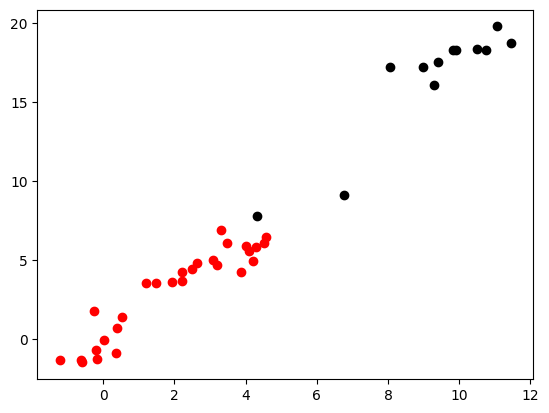

Score for k= 2 0.711663255638351


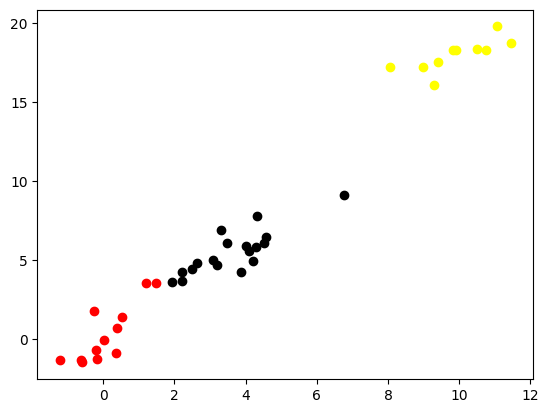

Score for k= 3 0.6929971471182135


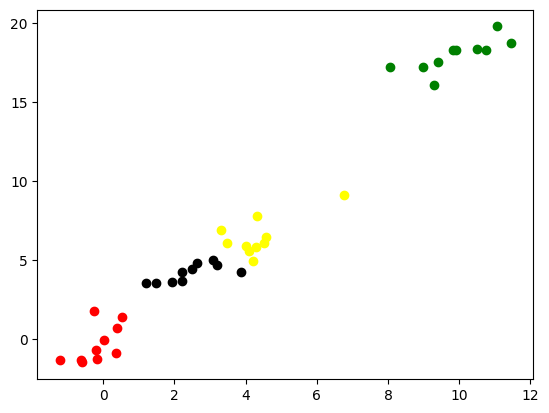

Score for k= 4 0.6668324230732491


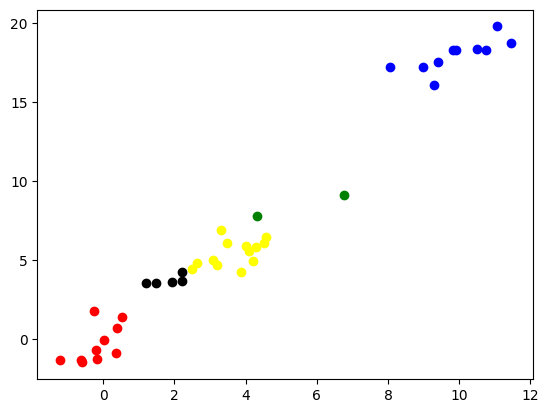

Score for k= 5 0.6369161586113199


In [327]:
def visualize_and_score(points, k):
    buckets = k_means(points, init_method="random_split", K=k, max_iters=100)

    colors = ['red', 'black', 'yellow', 'green', 'blue']
    for i, bucket in enumerate(buckets):
        for point in bucket:
            plt.scatter(point[0], point[1], color=colors[i])

    plt.show()

    # Print silhouette score
    score = silhouette_score(buckets)
    print("Score for k=", k, score)

for k in range(2, 6):
    visualize_and_score(points, k)


K = 2 gives the highest silhouette score of 0.77 hence the best K value